# 1. Data Wrangling

In [ ]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [35]:
#Load the user engagement data
user_engagement = pd.read_csv('takehome_user_engagement.csv')

In [36]:
user_engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [37]:
#Check number of users and logins
print('There were {} users and {} total logins'.format(
    user_engagement['user_id'].nunique(), len(user_engagement)
))

There were 8823 users and 207917 total logins


In [38]:
# Convert time_stamp into datetime format
user_engagement['time_stamp'] = pd.to_datetime(
    user_engagement['time_stamp'], format='%Y-%m-%d %H:%M:%S'
)

In [39]:
# Define a function to see if a user logged in on 3 seperate days in a 7-day period.
def logged_in_days(df, days=7, logins=3):
    from datetime import timedelta
    
    # Drop duplicate days and sort by day
    df['date'] = df['time_stamp'].dt.date
    df = df.drop_duplicates(subset='date').sort_values('date')
    
    # Calculate number of days that have passed for every 3 logins
    passed_days = df['date'].diff(periods=logins-1)
    
    # Check if any passed time is less than 7 days
    return any(passed_days <= timedelta(days=days))

In [40]:
# Run this function for all users
adopted = user_engagement.groupby('user_id').apply(logged_in_days)
adopted.name = 'adopted_user'

In [41]:
print('There were {} adopted users out of {} users'.format(
    sum(adopted), len(adopted)))

There were 1656 adopted users out of 8823 users


In [43]:
# Load user data
# some of the columns such as name, email address are not required to be loaded
cols = ['object_id', 'creation_source', 'creation_time', 
        'last_session_creation_time', 'opted_in_to_mailing_list',
        'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id']

takehome_users = pd.read_csv('takehome_users.csv', usecols=cols)

In [44]:
takehome_users.head()

,object_id,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [45]:
# Five Organizations with the most users
takehome_users['org_id'].value_counts().head()

0    319
1    233
2    201
3    168
4    159
Name: org_id, dtype: int64

In [48]:
# Five Users with the most invites
takehome_users['invited_by_user_id'].value_counts().head()

10741.0    13
2527.0     12
11770.0    11
1525.0     11
2308.0     11
Name: invited_by_user_id, dtype: int64

In [49]:
# Remove those two columns(or features)
takehome_users = takehome_users.drop(['org_id', 'invited_by_user_id'], axis=1)

In [50]:
# Create a feature of the user history
# Convert both time features into datetime
takehome_users['creation_time'] = pd.to_datetime(
    takehome_users['creation_time'], format='%Y-%m-%d %H:%M:%S')
takehome_users['last_session_creation_time'] = pd.to_datetime(
    takehome_users['last_session_creation_time'], unit='s')

# calculate user history, defined as number of days between account creation and last use
takehome_users['history'] = takehome_users['last_session_creation_time'] - takehome_users['creation_time']
takehome_users['history'] = takehome_users['history'].dt.days

# Calculate account age, which is defined as number of days since account creation and now
# Let's use the latest date in creation_time
latest = max(takehome_users['creation_time'])
takehome_users['account_age'] = latest - takehome_users['creation_time']
takehome_users['account_age'] = takehome_users['account_age'].dt.days

# Drop the two original columns
takehome_users = takehome_users.drop(['creation_time', 'last_session_creation_time'], axis=1)

In [51]:
takehome_users.head()

,object_id,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,history,account_age
0,1,GUEST_INVITE,1,0,0.0,38
1,2,ORG_INVITE,0,0,136.0,196
2,3,ORG_INVITE,0,0,0.0,437
3,4,GUEST_INVITE,0,0,1.0,374
4,5,GUEST_INVITE,0,0,5.0,498


In [52]:
takehome_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_source             12000 non-null  object 
 2   opted_in_to_mailing_list    12000 non-null  int64  
 3   enabled_for_marketing_drip  12000 non-null  int64  
 4   history                     8823 non-null   float64
 5   account_age                 12000 non-null  int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 562.6+ KB


There were 8823 users who had "user history" out of 12000. It was not clear from the challenge description whether data for other users were missing, or don't exist at all. However, given there are users who has history of 0 days, I think the engagement data for the other users were simply missing. Therefore, I will remove these users from the analysis.

In [53]:
# merge user data and "adopted user" variable
takehome_users = takehome_users.set_index('object_id')
takehome_users.index.name = 'user_id'
data = pd.concat([takehome_users, adopted], axis=1, join='inner')
data['adopted_user'] = data['adopted_user'].astype(int)

# 2. EDA

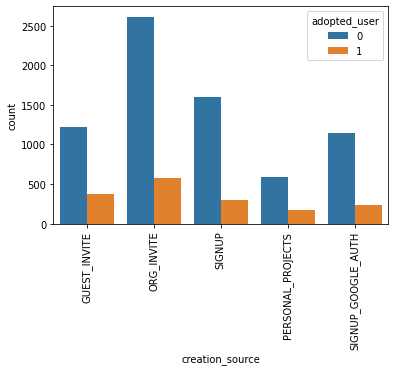

In [54]:
# Create source and adopted user
_ = sns.countplot(x='creation_source', data=data, hue='adopted_user')
_ = plt.xticks(rotation=90)

In [55]:
# let's do a chi2 test, since there was not much difference among creation sources
from scipy.stats import chi2_contingency
crosstab = pd.crosstab(data['creation_source'], data['adopted_user'])
results = chi2_contingency(crosstab)
print('chi2 = {}\tp = {}'.format(results[0], results[1]))

chi2 = 41.27933208242451	p = 2.3526508745340972e-08


In [63]:
# Show the difference
data.groupby('creation_source')['adopted_user'].apply(lambda x: sum(x)/len(x))

creation_source
GUEST_INVITE          0.232368
ORG_INVITE            0.180050
PERSONAL_PROJECTS     0.225131
SIGNUP                0.159115
SIGNUP_GOOGLE_AUTH    0.172563
Name: adopted_user, dtype: float64

In [64]:
# Check mailing list
data.groupby('opted_in_to_mailing_list')['adopted_user'].apply(lambda x: sum(x)/len(x))

opted_in_to_mailing_list
0    0.185994
1    0.192722
Name: adopted_user, dtype: float64

In [68]:
def z_test(df, col, target='adopted_user'):
    from statsmodels.stats.weightstats import CompareMeans
    opted_in = df.loc[data[col]==1, target]
    opted_out = df.loc[data[col]==0, target]
    z_data = CompareMeans.from_data(opted_in, opted_out)
    z, p = CompareMeans.ztest_ind(z_data)
    print('For {}, z = {}, p = {}'.format(col, z, p))

In [69]:
z_test(data, 'opted_in_to_mailing_list')

For opted_in_to_mailing_list, z = 0.7029779128148219, p = 0.4820695142048773


In [70]:
# Check marketing drip
data.groupby('enabled_for_marketing_drip')['adopted_user'].apply(lambda x: sum(x)/len(x))

enabled_for_marketing_drip
0    0.186982
1    0.191648
Name: adopted_user, dtype: float64

In [71]:
z_test(data, 'enabled_for_marketing_drip')

For enabled_for_marketing_drip, z = 0.40292649500940364, p = 0.6870022995069647


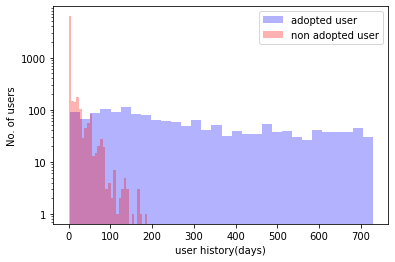

In [72]:
# History and Adopted user
def plot_hist_days(df, col, xlabel):
    _ = plt.hist(df.loc[data['adopted_user']==1, col], 
                 bins=30, alpha=0.3, color='b', label='adopted user')
    _ = plt.hist(df.loc[data['adopted_user']==0, col], 
                 bins=30, alpha=0.3, color='r', label='non adopted user')
    _ = plt.yscale('log')
    _ = plt.legend()
    _ = plt.xlabel(xlabel)
    _ = plt.ylabel('No. of users')
    _ = plt.yticks([1, 10, 100, 1000], ['1', '10', '100', '1000'])
plot_hist_days(data, 'history', 'user history(days)')

It is pretty clear from above plot that users with long history are more likely to be adopted users.

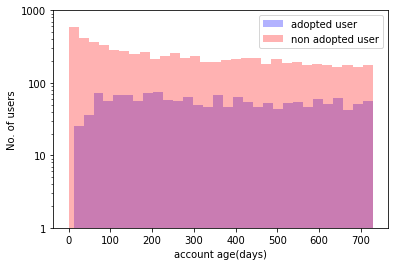

In [73]:
plot_hist_days(data, 'account_age', 'account age(days)')

Adoption rate is lower in very new accounts. Other than that, the adoption rate didn't change much over the past two years.

# 3. Modelling

In [77]:
# Create dummy variable for creation source
source_creation = pd.get_dummies(data['creation_source'], drop_first=True)
model_data = pd.concat([data, source_creation], axis=1).drop('creation_source', axis=1)
y = model_data['adopted_user']
X = model_data.drop('adopted_user', axis=1)
# though account_age and history have different scales than other features,
# I plan to use random forest model, which is not affectd by the different scales
# no need to scale the data
# create training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=42)

In [78]:
# Use random forest model with balanced class weights (for imbalance in the data)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
clf = RandomForestClassifier(random_state=42, class_weight='balanced')

# Use CV to tune number of trees
params = {'n_estimators': [10, 50, 100, 200]}
model = GridSearchCV(clf, params)
model.fit(X_train, y_train)
print('Best parameters were', model.best_params_)
print('Best average precision was', model.best_score_)

Best parameters were {'n_estimators': 50}
Best average precision was 0.962521322728487


In [80]:
# Model Evluation 
from sklearn.metrics import classification_report, accuracy_score
model = RandomForestClassifier(
    random_state=42, class_weight='balanced', n_estimators=100
)
model.fit(X_train, y_train)
y_pred = model.predict(Xtest)
print('Accuracy of test set was', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy of test set was 0.9524025385312783
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1792
           1       0.88      0.86      0.87       414

    accuracy                           0.95      2206
   macro avg       0.92      0.92      0.92      2206
weighted avg       0.95      0.95      0.95      2206



In [81]:
# take a look at feature importance
imp = pd.Series(model.feature_importances_, index=X.columns)
imp = imp.sort_values(ascending=False)
print(imp)

history                       0.896213
account_age                   0.088842
opted_in_to_mailing_list      0.003002
SIGNUP                        0.002919
enabled_for_marketing_drip    0.002682
ORG_INVITE                    0.002350
PERSONAL_PROJECTS             0.002069
SIGNUP_GOOGLE_AUTH            0.001923
dtype: float64


It is clear that the user history is the most important feature. Based on this, I recommend that an effective way of growing adopted users might be encouraging existing users to log in and use the software after they had accounts for a while.

Account age has some importance, but there is nothing can be done to change that.

Mailing list and marketing drip are not effective.